# plug-in_scapy_scran

In [1]:
import datetime

print("Thomas Walle\n")
print(datetime.datetime.now())

Thomas Walle

2021-02-19 14:38:17.883436


##### People involved


- [Alejandro Jimenez-Sanchez](https://www.mskcc.org/research/ski/labs/members/alejandro-sanchez-01)
- [Dana Pe'er](https://www.mskcc.org/research/ski/labs/dana-pe-er)

### Aims of this script:
<a id="aims"></a>

1. [Create input for scran from scanpy](#out) <font color=green>DONE</font>
0. [Instructions to run scran](#sctransform) <font color=green>DONE</font>
0. [Read-in scran output to scanpy](#in) <font color=green>DONE</font>

### References


- [Paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0947-7)
- [GitHub](https://github.com/MarioniLab/scran)
- [Package](https://bioconductor.org/packages/devel/bioc/html/scran.html)
- [Tutorial_1](https://bioconductor.org/packages/devel/bioc/vignettes/scran_final/inst/doc/scran.html)
- [Tutorial_2](https://alexslemonade.github.io/training-modules/scRNA-seq/01-normalizing_scRNA-seq.nb.html)

In [2]:
# Which python
import sys

sys.path[2]

'/home/wallet/miniconda3/envs/2020_Peer_PDAC_dev_Lowe/lib/python3.8'

## Packages

In [3]:
# Packages
import scipy
from scipy import io
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse
from matplotlib import rcParams

%matplotlib inline
sns.set_style("white")
warnings.filterwarnings('ignore')

## Functions

In [4]:
# Functions

# Count distribution
def total_molecules_per_cell(adat, count=str):

    # Plot distribution of total molecules per cell
    a = adat.copy()

    print("Median total count of UMI is:", np.median(a.obs[count]))

    # Per cell (Total molecules per cell)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,
                                        ncols=1,
                                        sharex=True,
                                        figsize=(15, 5))

    a.obs[count][a.obs[count] != 0].plot(kind="hist",
                                         bins=100,
                                         ax=ax1,
                                         color="r")
    a.obs[count][a.obs[count] != 0].plot(kind="kde", ax=ax2, color="r")
    a.obs[count][a.obs[count] != 0].plot(kind="box",
                                         vert=False,
                                         ax=ax3,
                                         color="r")

    x = ax3.set_xlabel("Molecule counts "+ count +" per cell")

    return None


# Randomize cells for plotting UMAP
def randomize_cells(anndata_object):

    "Randomize cells for plotting UMAP"

    index_list = np.arange(anndata_object.shape[0])
    np.random.shuffle(index_list)
    anndata_object = anndata_object[index_list]

    return anndata_object


# Percentage of variance explained
def pcs_variance(annadata_object, var_explained):

    for idx, var in enumerate(annadata_object.uns["pca"]["variance_ratio"]):

        var_exp = np.sum(annadata_object.uns["pca"]["variance_ratio"][:idx])

        if var_exp > var_explained:

            return idx


# Plot function
def plot_cumsum(pc_var, pc, cumvar, color="r"):
    
    plt.figure()
    plt.plot(np.cumsum(pc_var), c="k", zorder=0)
    plt.scatter(pc, cumvar, c=color, zorder=1)
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')  #for each component
    plt.title('Dataset Explained Variance')
    plt.show()


# kneepoint
def kneepoint(vec, color="r"):
    curve = [1 - x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst *
                           numpy.matlib.repmat(lineVecNorm, nPoints, 1),
                           axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine**2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)

    cumvar = np.cumsum(vec[:idxOfBestPoint + 1])[-1]

    print("Kneepoint happens at PC:")

    print("PC", idxOfBestPoint)

    print("The cumulativate variation explaind is:")

    print(cumvar)

    plot_cumsum(vec, idxOfBestPoint, cumvar, color)

    return idxOfBestPoint


# Treatment colors
treatment_colors = ["red", "green", "yellow", "blue"]


# Select PCs
def select_pcs(adata_obj, color="r"):

    # Slope function
    def slope(x1, y1, x2, y2):
        return (y2 - y1) / (x2 - x1)

    pc_v = adata_obj.uns["pca"]["variance_ratio"]

    max_slope = slope(1, np.cumsum(pc_v[0])[-1], 2, np.cumsum(pc_v[:2])[-1])

    for i, v in enumerate(pc_v):

        x1 = i
        x2 = x1 + 1

        if x1 == 0:
            y1 = np.cumsum(pc_v[x1])[-1]
        else:
            y1 = np.cumsum(pc_v[:x1 + 1])[-1]

        y2 = np.cumsum(pc_v[:x2 + 1])[-1]

        s = slope(x1, y1, x2, y2)

        if s <= max_slope / 10:

            print("Change of slope no less than 1/10 of PC1 to PC2 is in:")

            print("PC", x1)

            print("The cumulativate variation explaind is:")

            print(y1)

            break

    plot_cumsum(pc_v, x1, y1, color)


# Genes to potentially remove
def genes_to_keep_remove(adata_obj):

    # Ribosomal genes
    riboL = [gene for gene in adata_obj.var.index if "RPL" == gene[0:3]]
    riboS = [gene for gene in adata_obj.var.index if "RPS" == gene[0:3]]

    ribo = list(set(riboL + riboS))

    ribosomal_genes_df = pd.read_csv(
        "/home/ec2-user/software/gene_sets/qc/ribosomal_genes.csv", sep=",")

    ribos = ribo + list(ribosomal_genes_df["ribosomal_genes"])

    # Malat1
    malat1 = ["MALAT1"]

    # Mitochondrial genes
    mitos = [gene for gene in adata_obj.var.index if "MT-" == gene[0:3]]
    mito_ribos = [gene for gene in adata_obj.var.index if "MRPL" == gene[0:3]]

    # Actin genes
    actns = [gene for gene in adata_obj.var.index if "ACTN" == gene[0:4]]

    remove_genes = {
        "malat1": malat1,
        "mitos": mitos,
        "mito_ribos": mito_ribos,
        "actns": actns,
        "ribos": ribos
    }

    genes_to_remove = set()
    for geneset in remove_genes.values():

        genes_to_remove = genes_to_remove | set(geneset)

    keep_genes = list(set(adata_obj.var.index) - genes_to_remove)

    return (keep_genes, remove_genes)


# 64 color palette
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#6A3A4C",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72"
]

## Load data


In [5]:
# Read raw adata
PATH = '/data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/output_data/'
FILE = '2021_PDAC_RT_Huber_Walle_raw_data_annotated_emptydrops_noribo_nomito_clustered_nodrops_doublets_nodoubs_libsize_log1p_clustered_10000hv_genes_curated_marker_genes_210216_leukocytes.h5ad'
adata = sc.read_h5ad(PATH + FILE)
samples_to_exclude = []
adata.shape

(42980, 20962)

## Dealing with negative size factors

It is possible for the deconvolution algorithm to yield negative estimates for the size factors. These values are obviously nonsensical and `computeSumFactors` will raise a warning if they are encountered. Negative estimates are mostly commonly generated from low quality cells with few expressed features, such that most genes still have zero counts even after pooling. They may also occur if insufficient filtering of low-abundance genes was performed.

To avoid negative size factors, the best solution is to increase the stringency of the filtering.

If only a few negative size factors are present, they are likely to correspond to a few low-quality cells with few expressed features. Such cells are difficult to normalize reliably under any approach, and can be removed by increasing the stringency of the quality control.

If many negative size factors are present, it is probably due to insufficient filtering of low-abundance genes. This results in many zero counts and pooled size factors of zero, and can be fixed by filtering out more genes with a higher `min.mean` - see “Gene selection” below.

Another approach is to increase in the number of `sizes` to improve the precision of the estimates. This reduces the chance of obtaining negative size factors due to estimation error, for cells where the true size factors are very small.

As a last resort, `positive=TRUE` is set by default, which uses `cleanSizeFactors` to coerce any negative estimates to positive values. This ensures that, at the very least, downstream analysis is possible even if the size factors for affected cells are not accurate. Users can skip this step by setting `positive=FALSE` to perform their own diagnostics or coercions.

REF: https://rdrr.io/bioc/scran_final/man/computeSumFactors.html

`scTranform` filters out genes that are expressed in no more than 5 cells by default. However, when applying `scran`, negative factors were present in data if the number of cells was limited to 5. By limiting the cells to 10, no negative factors were found. Thus, for consistency I remove genes that are expressed in no more than 10 cells. Similarly, `scanpy` tutorial suggests 3 cells as a threshold as a basic filter, but for the reasons mentioned above, I think 10 is a reasonable balance.

REF: https://icb-scanpy-tutorials.readthedocs-hosted.com/en/latest/pbmc3k.html

#define samples to normalize (if necessary)
a_length=len(adata)
print('length of original adata is', a_length)

adata = adata[~adata.obs['sample_id'].isin(samples_to_exclude)]
b_length=len(adata)
print('length of filtered adata is', b_length)

In [6]:
### Remove genes expressed in less tha 10 cells
sc.pp.filter_genes(adata, min_cells=10)

adata.shape

(42980, 18119)

In [8]:
#add raw .X
adata1 = adata.raw

In [9]:
adata

AnnData object with n_obs × n_vars = 42980 × 18119
    obs: 'batch', 'primary_tumor', 'LogProb_emptydrops', 'PValue_emptydrops', 'FDR_emptydrops', 'Limited', 'total_molecules', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'pheno', 'true_cell_emptydrops', 'empty_droplet_sig', 'doublets', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'major_subsets'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means',

In [10]:
#filter genes
adata1 = adata1[adata.obs_names,adata.var_names]

In [11]:
#add .X to adata
adata1.obs = adata.obs

In [12]:
adata.X = adata1.X

In [13]:
print(adata.X)

  (0, 3607)	1.0
  (0, 2899)	1.0
  (0, 2460)	1.0
  (0, 13171)	1.0
  (0, 12455)	1.0
  (0, 12890)	1.0
  (0, 9260)	1.0
  (0, 16677)	1.0
  (0, 9182)	1.0
  (0, 7182)	2.0
  (0, 8512)	1.0
  (0, 8588)	128.0
  (0, 9726)	4.0
  (0, 4910)	1.0
  (0, 8972)	1.0
  (0, 11575)	1.0
  (0, 6596)	1.0
  (0, 13473)	1.0
  (0, 13586)	1.0
  (0, 13541)	1.0
  (0, 9608)	1.0
  (0, 13587)	1.0
  (0, 7935)	1.0
  (0, 17008)	1.0
  (0, 7889)	1.0
  :	:
  (42979, 13887)	1.0
  (42979, 1104)	1.0
  (42979, 3990)	1.0
  (42979, 11560)	1.0
  (42979, 17003)	2.0
  (42979, 5054)	1.0
  (42979, 16054)	3.0
  (42979, 1108)	1.0
  (42979, 6224)	2.0
  (42979, 1161)	1.0
  (42979, 2576)	1.0
  (42979, 11032)	1.0
  (42979, 2594)	4.0
  (42979, 14269)	3.0
  (42979, 3110)	2.0
  (42979, 16688)	1.0
  (42979, 13577)	1.0
  (42979, 9475)	1.0
  (42979, 8487)	1.0
  (42979, 7529)	2.0
  (42979, 12196)	1.0
  (42979, 7746)	1.0
  (42979, 5490)	1.0
  (42979, 12037)	1.0
  (42979, 2864)	1.0


## Prepare scran input files

In [14]:
# Calculate total molecules per cell
adata1 = adata.copy()

In [15]:
### QC metrics
sc.pp.calculate_qc_metrics(
    adata1,
    expr_type="counts",
    var_type="genes",
    inplace=True
)

Median total count of UMI is: 2019.0


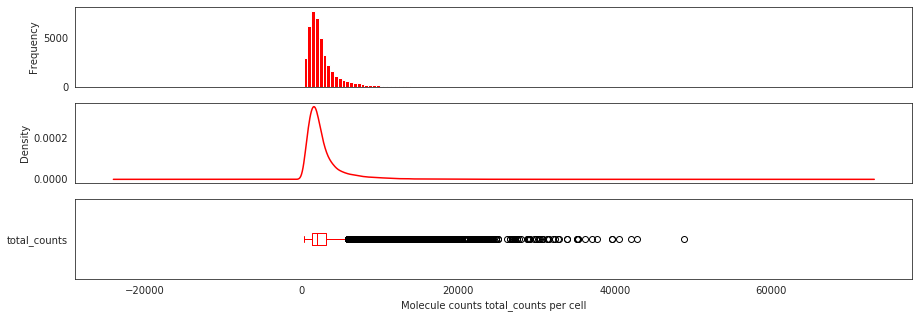

In [16]:
total_molecules_per_cell(adata1, count="total_counts")

### Sparse gene matrix


In [17]:
mtx_file = sparse.csr_matrix(adata1.X)

mtx_file

<42980x18119 sparse matrix of type '<class 'numpy.float32'>'
	with 42340660 stored elements in Compressed Sparse Row format>

In [18]:
# Write sparse matrix
PATH = "/data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/output_data/scran/"
PATH += "input/"
FILE = "combo_fixed_counts_v1.mtx"

scipy.io.mmwrite(PATH + FILE, mtx_file)

### Gene names

In [19]:
g_file = pd.Series(adata1.var_names)

g_file

0          A1BG
1          A1CF
2           A2M
3         A2ML1
4        A4GALT
          ...  
18114    ZYG11A
18115    ZYG11B
18116       ZYX
18117     ZZEF1
18118      ZZZ3
Length: 18119, dtype: object

In [20]:
# Write gene names
PATH = "/data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/output_data/scran/"
PATH += "input/"
FILE = "genes.csv"

g_file.to_csv(PATH + FILE, index=False, header=False)

### Cell names

In [21]:
adata1.obs_names

Index(['235000971515614-T23', '239932640480493-T23', '204762107788076-T22',
       '134376349133724-T13', '226970310199197-N08', '195958645679853-T12',
       '135150471440675-T02', '161864228190941-T02', '169579780138907-T12',
       '196113251555110-T12',
       ...
       '157684165986678-T03', '165232449043884-T02', '169723796548966-T15',
       '197185786014964-T18', '126706311425307-T17', '121879170824995-T16',
       '166288091176166-T15', '120864485590886-T10', '169014034020203-T11',
       '129565717587827-T17'],
      dtype='object', name='cell_ID', length=42980)

In [22]:
bc_file = pd.Series(adata1.obs_names)

bc_file

0        235000971515614-T23
1        239932640480493-T23
2        204762107788076-T22
3        134376349133724-T13
4        226970310199197-N08
                ...         
42975    121879170824995-T16
42976    166288091176166-T15
42977    120864485590886-T10
42978    169014034020203-T11
42979    129565717587827-T17
Name: cell_ID, Length: 42980, dtype: object

In [23]:
# Write gene names
PATH = "/data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/output_data/scran/"
PATH += "input/"
FILE = "cells.csv"

bc_file.to_csv(PATH + FILE, index=False, header=False)

## Run scran


On the terminal do:

```
PATH_I=~/scran_final/input/
PATH_O=~/scran_final/input/output/
PATH_T=~/run_scran.R

m_file=combo_fixed_counts_v1.mtx
g_file=genes.csv
bc_file=cells.csv
ofile=sct_combo_fixed_counts_v1.csv
tfile=run_scran.R

Rscript $PATH_T$tfile $PATH_I$m_file $PATH_I$g_file $PATH_I$bc_file $PATH_O$ofile
```

## Load scran output


In [6]:
import anndata2ri

anndata2ri.activate()

%load_ext rpy2.ipython

In [7]:
!ls /data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/scran_final/output/

sct_combo_fixed_counts_v1.csv  sct_combo_fixed_counts_v1.rds


Install following R packages only first time

In [8]:
#%%R

#paste("R", "T", sep = "")

In [9]:
#%%R

#BiocManager::install("S4Vectors")
#BiocManager::install("SummarizedExperiment")
#BiocManager::install("SingleCellExperiment")

In [10]:
%%R -o scr_matrix

library(Matrix)

PATH1 <- "/data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/"
PATH2 <- "scran_final/output/"

PATH <- paste(PATH1, PATH2, sep = "")

FILE <- "sct_combo_fixed_counts_v1.rds"

FILE <- paste(PATH, FILE, sep = "")

scr_matrix <- readRDS(FILE)

scr_matrix <- as(scr_matrix, 'SingleCellExperiment')

scr_matrix

class: SingleCellExperiment 
dim: 18094 49220 
metadata(0):
assays(2): X logcounts
rownames(18094): MAGI1 MAP2K5 ... ABHD1 MICU3
rowData names(1): value
colnames(49220): 195967088802035-N07 236170007923556-T24 ...
  166351441357222-T11 164753413659372-T02
colData names(0):
reducedDimNames(0):
spikeNames(0):
altExpNames(0):


In [11]:
# Add log counts from scran
scr_matrix.X = scr_matrix.layers["logcounts"]

scr_matrix.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
adata1scr = sc.AnnData(X=np.array(scr_matrix.X),
                       obs={'obs_names': scr_matrix.obs_names},
                       var={'var_names': scr_matrix.var_names})

adata1scr

AnnData object with n_obs × n_vars = 49220 × 18094

In [13]:
### QC metrics
sc.pp.calculate_qc_metrics(adata1scr,
                           expr_type="counts",
                           var_type="genes",
                           inplace=True)

In [14]:
a = adata1scr.copy()

Median total count of UMI is: 1029.676


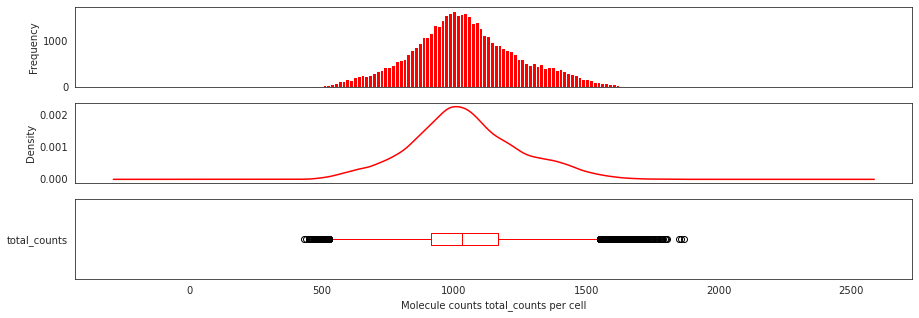

In [15]:
total_molecules_per_cell(a, count="total_counts")

In [16]:
!ls /data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/scran_final/output/

sct_combo_fixed_counts_v1.csv  sct_combo_fixed_counts_v1.rds


In [17]:
### Save
PATH = "/data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/scran_final/output/"
FILE = "PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter-X-leukocytes_scran_final.h5ad"

adata1scr.write(PATH + FILE)

# End

In [ ]:
"/data/peer/wallet/Jupyter/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter/scran_final/output/PAAD-X-Peng_Sun-X-2019-X-10.1038s41422-019-0195-y-X-Jupyter-X-leukocytes_scran_final.h5ad"